In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [8]:
#funding
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df_fund=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
df_fund.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'funding_country': 'Source'}, inplace=True)
df_fund=df_fund[~(df_fund['subjarea'].isin(physical_sciences))]
df_fund=df_fund[df_fund['Mention_country']==df_fund['Source']]
df_fund=df_fund.groupby(['year', 'Mention_country'])['count'].sum().reset_index()
df_fund=df_fund[(df_fund['year'].isin(np.arange(2002,2020,1)))].reset_index(drop=True)
df=df_fund.copy()

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))

# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)

afg
ago
alb
arm
aze
bdi
ben
bfa
bhr
bih
blr
bol
caf
civ
cmr
dji
dom
dza
eri
gab
gmb
gtm
hnd
hti
irq
jam
kaz
kgz
khm
lao
lbr
lby
lso
mda
mdg
mkd
mli
mmr
mng
moz
mrt
mus
mwi
nam
ner
nic
pan
pry
pse
qat
rwa
sen
sle
slv
som
syr
tcd
tgo
tjk
tkm
tto
uzb
yem
zmb
64


In [9]:
df_complete['hue']=df_complete['treated_CW']*2 +df_complete['treated_GC']*3+df_complete['treated_GO']

In [10]:
df_p=df_complete[df_complete['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year'].min()-df_p['year']
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~treated_GC * time + treated_GO * time +treated_CW * time +log_gdp +C(Mention_country) + C(year)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1132.
Date:                Sun, 16 Mar 2025   Prob (F-statistic):          5.68e-136
Time:                        21:38:21   Log-Likelihood:                -361.22
No. Observations:                1305   AIC:                             1036.
Df Residuals:                    1148   BIC:                             1849.
Df Model:                         156                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 160, but rank is 12
  warnings.warn('covariance of constraints does not have full '


Text(0, 0.5, 'log Foreign Funding')

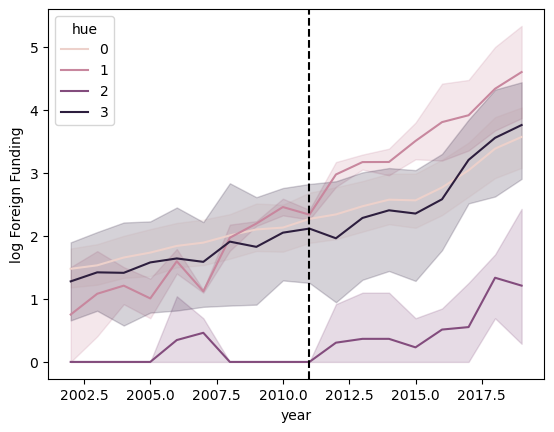

In [13]:
sns.lineplot(data=df_complete, x='year', y='log_count', hue='hue')
plt.axvline(2011, color='k', linestyle='--')
plt.ylabel('log Foreign Funding')

In [12]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~treated_GC * post + treated_GO * post +treated_CW * post +log_gdp+C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     43.69
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           6.65e-52
Time:                        21:38:38   Log-Likelihood:                -1974.0
No. Observations:                2610   AIC:                             4280.
Df Residuals:                    2444   BIC:                             5254.
Df Model:                         165                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 169, but rank is 21
  warnings.warn('covariance of constraints does not have full '
